Task 4.1

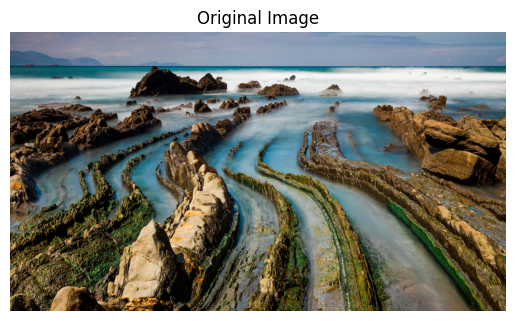

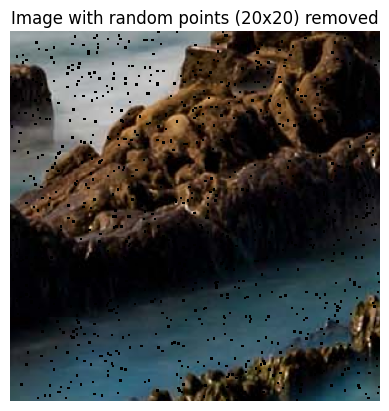

Iteration 0, Loss: 6352.2766
Iteration 100, Loss: 95.8831
Iteration 200, Loss: 67.9389
Iteration 300, Loss: 62.0050
Iteration 400, Loss: 58.7362
Iteration 500, Loss: 56.0370
Iteration 600, Loss: 54.2639
Iteration 700, Loss: 52.7206
Iteration 800, Loss: 51.3407
Iteration 900, Loss: 50.4507


RMSE: 0.0522
PSNR: 25.6404 dB


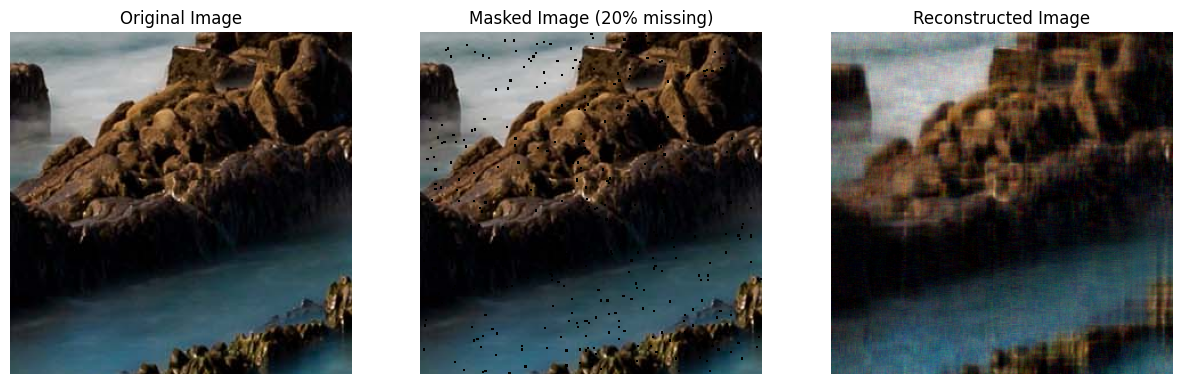

In [15]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from einops import rearrange
import os

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the image
image_tensor = torchvision.io.read_image("img.jpg")
image_tensor = image_tensor / 255.0  # Normalize pixel values to [0,1]

# Display the original image
plt.imshow(rearrange(image_tensor, 'c h w -> h w c').numpy())
plt.title("Original Image")
plt.axis('off')
plt.show()

# Crop the image to a smaller size for faster processing
cropped_image = T.functional.crop(image_tensor, 600, 800, 300, 300)


# Function to remove random points from the image
def apply_random_mask(image, num_points):
    # Flatten the image channels to a 2D array (3 x total_pixels)
    flattened_image = image.reshape(3, -1)

    # Randomly select indices to remove points
    random_indices = np.random.choice(flattened_image.shape[1], num_points * num_points, replace=False)

    # Set the selected random points to NaN
    flattened_image[:, random_indices] = torch.nan

    # Reshape the flattened image back to its original shape
    image_with_removed_points = flattened_image.reshape(image.shape)

    return image_with_removed_points

# Apply the function to the cropped image
mod_img_two = apply_random_mask(cropped_image, 30)

# Display the modified image with random points removed
plt.imshow(rearrange(mod_img_two, 'c h w -> h w c'))
plt.title("Image with random points (20x20) removed")
plt.axis('off')
plt.show()





# Matrix factorization using gradient descent
def low_rank_approximation(image_data, reduced_rank, steps=1000, learning_rate=0.01):
    image_data = image_data.to(device)

    # Initialize factor matrices A and B
    A_matrix = torch.randn(image_data.shape[0], image_data.shape[1], reduced_rank, requires_grad=True, device=device)
    B_matrix = torch.randn(image_data.shape[0], reduced_rank, image_data.shape[2], requires_grad=True, device=device)

    optimizer = torch.optim.Adam([A_matrix, B_matrix], lr=learning_rate)

    for iteration in range(steps):
        cumulative_loss = 0.0
        for ch in range(image_data.shape[0]):
            channel_data = image_data[ch, :, :]
            valid_mask = ~torch.isnan(channel_data)

            # Compute reconstruction loss
            reconstruction_diff = torch.mm(A_matrix[ch, :, :], B_matrix[ch, :, :]) - channel_data
            valid_diff = reconstruction_diff[valid_mask]
            loss = torch.norm(valid_diff)

            # Perform optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cumulative_loss += loss.item()

        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Loss: {cumulative_loss:.4f}")

    return A_matrix, B_matrix

# Reconstruction and evaluation function
def reconstruct_image_evaluation(orig_img, incomplete_img, rank):
    A_matrix, B_matrix = low_rank_approximation(incomplete_img, rank)
    reconstructed = incomplete_img.clone()

    # Rebuild each channel from A and B
    for ch in range(orig_img.shape[0]):
        reconstructed[ch, :, :] = torch.mm(A_matrix[ch, :, :], B_matrix[ch, :, :])

    return reconstructed

# Function to calculate RMSE
def compute_rmse(actual, estimated):
    mse_loss = F.mse_loss(actual, estimated, reduction='mean').item()
    return np.sqrt(mse_loss)

# Function to calculate PSNR
def compute_psnr(actual, estimated):
    mse_loss = F.mse_loss(actual, estimated).item()
    max_val = torch.max(actual)
    psnr_metric = 10 * torch.log10((max_val ** 2) / mse_loss)
    return psnr_metric

# Main function to run the image reconstruction and evaluation process
def execute_image_reconstruction(img_data, missing_data_fraction, rank):
    mod_img_two = apply_random_mask(img_data, missing_data_fraction)

    # Reconstruct the image
    reconstructed_img = reconstruct_image_evaluation(img_data, mod_img_two, rank)

    # Calculate performance metrics
    rmse_value = compute_rmse(img_data, reconstructed_img)
    psnr_value = compute_psnr(img_data, reconstructed_img)

    print(f"RMSE: {rmse_value:.4f}")
    print(f"PSNR: {psnr_value:.4f} dB")

    # Plot original, masked, and reconstructed images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(rearrange(img_data.cpu().detach().numpy(), 'c h w -> h w c'))
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(rearrange(mod_img_two.cpu().detach().numpy(), 'c h w -> h w c'))
    axs[1].set_title(f"Masked Image ({int(missing_data_fraction )}% missing)")
    axs[1].axis('off')

    axs[2].imshow(rearrange(reconstructed_img.cpu().detach().numpy(), 'c h w -> h w c'))
    axs[2].set_title("Reconstructed Image")
    axs[2].axis('off')

    plt.show()

# Execute the image reconstruction task
execute_image_reconstruction(cropped_image, missing_data_fraction=20, rank=50)


Task 4.2

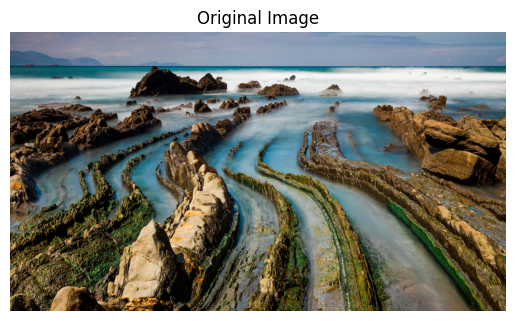

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


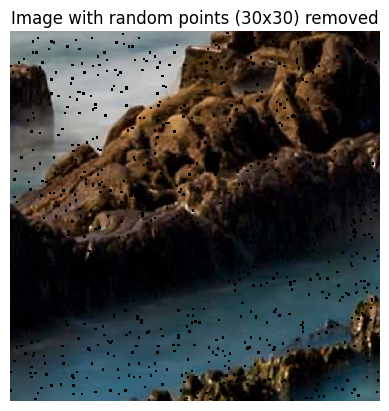

Iteration 0, Loss: 6325.3315
Iteration 100, Loss: 97.9036
Iteration 200, Loss: 68.4547
Iteration 300, Loss: 62.9361
Iteration 400, Loss: 59.2040
Iteration 500, Loss: 56.7240
Iteration 600, Loss: 54.5288
Iteration 700, Loss: 52.9193
Iteration 800, Loss: 51.4710
Iteration 900, Loss: 50.2986


RMSE: 0.0522
PSNR: 25.6496 dB


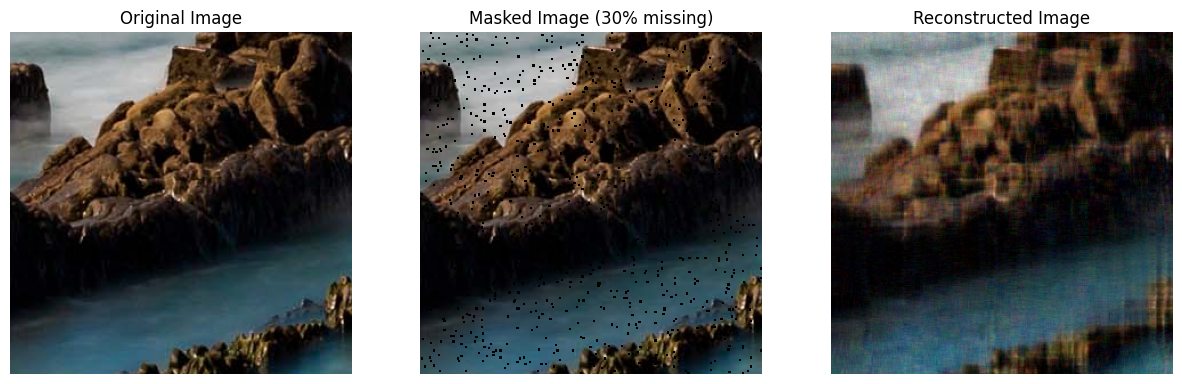

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from einops import rearrange
import os

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the image
image_tensor = torchvision.io.read_image("img.jpg")
image_tensor = image_tensor / 255.0  # Normalize pixel values to [0,1]

# Display the original image
plt.imshow(rearrange(image_tensor, 'c h w -> h w c').numpy())
plt.title("Original Image")
plt.axis('off')
plt.show()

# Crop the image to a smaller size for faster processing
cropped_image = T.functional.crop(image_tensor, 600, 800, 300, 300)


# Function to remove random points from the image
def apply_random_mask(image, num_points):
    # Flatten the image channels to a 2D array (3 x total_pixels)
    flattened_image = image.reshape(3, -1)

    # Randomly select indices to remove points
    random_indices = np.random.choice(flattened_image.shape[1], num_points * num_points, replace=False)

    # Set the selected random points to NaN
    flattened_image[:, random_indices] = torch.nan

    # Reshape the flattened image back to its original shape
    image_with_removed_points = flattened_image.reshape(image.shape)

    return image_with_removed_points

# Apply the function to the cropped image
mod_img_two = apply_random_mask(cropped_image, 30)

# Display the modified image with random points removed
plt.imshow(rearrange(mod_img_two, 'c h w -> h w c'))
plt.title("Image with random points (30x30) removed")
plt.axis('off')
plt.show()





# Matrix factorization using gradient descent
def low_rank_approximation(image_data, reduced_rank, steps=1000, learning_rate=0.01):
    image_data = image_data.to(device)

    # Initialize factor matrices A and B
    A_matrix = torch.randn(image_data.shape[0], image_data.shape[1], reduced_rank, requires_grad=True, device=device)
    B_matrix = torch.randn(image_data.shape[0], reduced_rank, image_data.shape[2], requires_grad=True, device=device)

    optimizer = torch.optim.Adam([A_matrix, B_matrix], lr=learning_rate)

    for iteration in range(steps):
        cumulative_loss = 0.0
        for ch in range(image_data.shape[0]):
            channel_data = image_data[ch, :, :]
            valid_mask = ~torch.isnan(channel_data)

            # Compute reconstruction loss
            reconstruction_diff = torch.mm(A_matrix[ch, :, :], B_matrix[ch, :, :]) - channel_data
            valid_diff = reconstruction_diff[valid_mask]
            loss = torch.norm(valid_diff)

            # Perform optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cumulative_loss += loss.item()

        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Loss: {cumulative_loss:.4f}")

    return A_matrix, B_matrix

# Reconstruction and evaluation function
def reconstruct_image_evaluation(orig_img, incomplete_img, rank):
    A_matrix, B_matrix = low_rank_approximation(incomplete_img, rank)
    reconstructed = incomplete_img.clone()

    # Rebuild each channel from A and B
    for ch in range(orig_img.shape[0]):
        reconstructed[ch, :, :] = torch.mm(A_matrix[ch, :, :], B_matrix[ch, :, :])

    return reconstructed

# Function to calculate RMSE
def compute_rmse(actual, estimated):
    mse_loss = F.mse_loss(actual, estimated, reduction='mean').item()
    return np.sqrt(mse_loss)

# Function to calculate PSNR
def compute_psnr(actual, estimated):
    mse_loss = F.mse_loss(actual, estimated).item()
    max_val = torch.max(actual)
    psnr_metric = 10 * torch.log10((max_val ** 2) / mse_loss)
    return psnr_metric

# Main function to run the image reconstruction and evaluation process
def execute_image_reconstruction(img_data, missing_data_fraction, rank):
    mod_img_two = apply_random_mask(img_data, missing_data_fraction)

    # Reconstruct the image
    reconstructed_img = reconstruct_image_evaluation(img_data, mod_img_two, rank)

    # Calculate performance metrics
    rmse_value = compute_rmse(img_data, reconstructed_img)
    psnr_value = compute_psnr(img_data, reconstructed_img)

    print(f"RMSE: {rmse_value:.4f}")
    print(f"PSNR: {psnr_value:.4f} dB")

    # Plot original, masked, and reconstructed images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(rearrange(img_data.cpu().detach().numpy(), 'c h w -> h w c'))
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(rearrange(mod_img_two.cpu().detach().numpy(), 'c h w -> h w c'))
    axs[1].set_title(f"Masked Image ({int(missing_data_fraction )}% missing)")
    axs[1].axis('off')

    axs[2].imshow(rearrange(reconstructed_img.cpu().detach().numpy(), 'c h w -> h w c'))
    axs[2].set_title("Reconstructed Image")
    axs[2].axis('off')

    plt.show()

# Execute the image reconstruction task
execute_image_reconstruction(cropped_image, missing_data_fraction=30, rank=50)


In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.gridspec as gridspec
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [ ]:
def train(net, lr, X, Y, epochs, verbose=False):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    X = X.to(device)
    Y = Y.to(device)
    net = net.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [12]:
def plot_reconstructed_and_original_image(original_img, net, X, crop, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)

    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    mse = nn.MSELoss()(crop, outputs.reshape(crop.shape))
    psnr = compute_psnr(outputs.reshape(crop.shape), crop)
    ax0.text(0.5, -0.1, f"MSE: {mse.item():.6f}\nPSNR: {psnr}", transform=ax0.transAxes, ha="center", va="center", bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))


    ax1.imshow(rearrange(original_img.cpu().detach().numpy(), 'c h w -> h w c'))
    ax1.set_title("Image With Missing Points")

    ax2.imshow(rearrange(crop.cpu().detach().numpy(), 'c h w -> h w c'))
    ax2.set_title("Complete Original Image")

    for a in [ax0, ax1, ax2]:
        a.axis("off")



    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [ ]:
from sklearn import preprocessing
def complete_img_rff(original_image, image_with_missing_data, num_features, sigma, epochs=1000, learning_rate=0.1, title=""):
    X_train, _ = create_coordinate_map(torch.tensor(image_with_missing_data))
    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_train.cpu())
    scaled_train_X = torch.tensor(scaler_X.transform(X_train)).to(device).float()
    _, Y_train = create_coordinate_map(torch.tensor(original_image))
    X_train_rff = create_rff_features(scaled_train_X, num_features, sigma)
    net = LinearModel(X_train_rff.shape[1], Y_train.shape[1])
    train(net, learning_rate, X_train_rff, Y_train, epochs=epochs)
    plot_reconstructed_and_original_image(torch.tensor(image_with_missing_data), net, X_train_rff, original_image, title)

<ipython-input-10-58d32ee9be5c>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, _ = create_coordinate_map(torch.tensor(image_with_missing_data))
<ipython-input-10-58d32ee9be5c>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, Y_train = create_coordinate_map(torch.tensor(original_image))
<ipython-input-10-58d32ee9be5c>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_reconstructed_and_original_image(torch.tensor(image_with_missing_data), net, X_train_rff, original_image, title)
/usr/local/lib/python3.10/dist-packages/mat

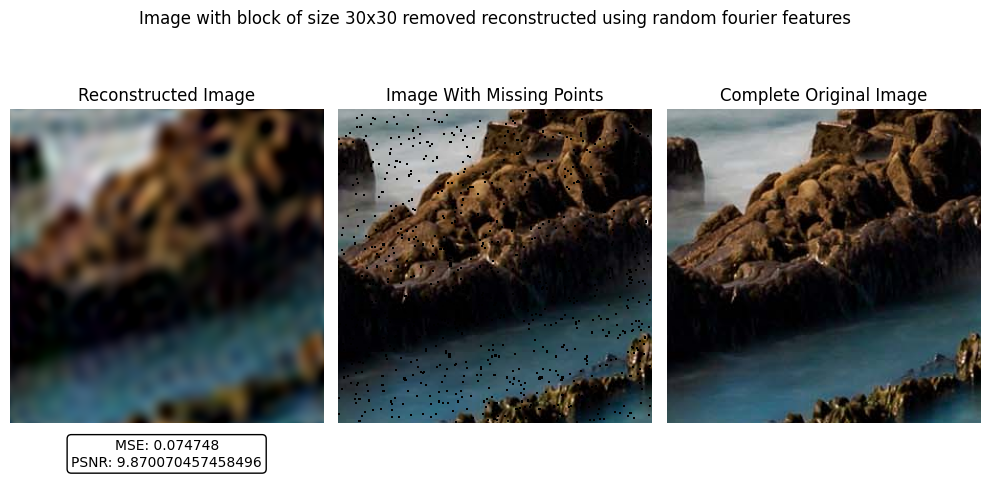

In [13]:
complete_img_rff(cropped_image, mod_img_two, 8000, 0.08, title='Image with block of size 30x30 removed reconstructed using random fourier features')

We got much better image reconstruction using matrix factorization with gradient descent compared to linear regression with random Fourier features (RFF). This is because factorization does a better job of finding patterns in the data, helping it predict the missing parts of the image more accurately. Gradient descent also improves the results step by step. On the other hand, linear regression with RFF isn't as good at handling complex patterns, so it doesn't reconstruct the image as well.
